# Project start
<a href="https://github.com/Bae-ChangHyun"><img src="https://img.shields.io/badge/Github-000000?style=flat&logo=github&logoColor=ffffff&labelColor=000000&link=https%3A%2F%2Fgithub.com%2FBae-ChangHyun"/></a> <br>
<a href="https://changsroad.tistory.com/"><img src="https://img.shields.io/badge/Tistory-f44336?style=flat&logo=tistory&logoColor=ffffff&link=https%3A%2F%2Fchangsroad.tistory.com%2F"/></a> <br>
<a href="mailto:matthew624@naver.com"><img src="https://img.shields.io/badge/Naver-03C75A?style=flat&logo=naver&logoColor=ffffff&link=mailto%3Amatthew624%40naver.com"/></a><br>
<a href="https://dacon.io/competitions/official/236125/overview/description" target="_blank"><img align="center" alt="Dacom" title="Dacon" src="https://image.rocketpunch.com/company/136141/dacon_logo_1673999571.png?s=400x400&t=inside" width="2%" height="2%"></a><br>

# 전력사용량 예측 AI 경진대회


- 건물별 시간당 전력사용량을 예측하는 대회입니다.


- 건물별 전력사용량의 패턴을 파악하는게 핵심인 대회입니다.


- train data와 test data의 시간대가 다른, 시계열 문제입니다. 시계열 문제를 단순 회귀문제로 변환하여 푸는 방법을 알아봅니다.


# 1. 라이브러리, 데이터 불러오기

In [36]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rc('axes',unicode_minus=False)

import seaborn as sns

# 모델들, 성능 평가
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score

#import lightgbm as lgb
from lightgbm import LGBMRegressor
#from lightgbm.sklearn import LGBMRegressor

# 상관관계 분석, VIF : 다중공선성 제거
from statsmodels.stats.outliers_influence import variance_inflation_factor

# KFold(CV), partial : optuna를 사용하기 위함
from sklearn.model_selection import KFold
from functools import partial

# hyper-parameter tuning을 위한 라이브러리, optuna
import optuna

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# flag setting
feature_reducing = False # 'pca' or 'fi'

In [3]:
# 데이터를 불러옵니다.
train = pd.read_csv('data/train.csv')
building_info = pd.read_csv('data/building_info.csv')
test = pd.read_csv('data/test.csv')
print(train.shape, building_info.shape, test.shape)

(204000, 10) (100, 7) (16800, 7)


# 2. EDA
- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.

- class imbalance, target distribution, outlier, correlation을 확인합니다.

- num_date_time: 건물번호와 시간

- 일시: 측정일시


In [4]:
# train과 test의 컬럼이 차이가 있음.
train.columns
test.columns

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)',
       '일조(hr)', '일사(MJ/m2)', '전력소비량(kWh)'],
      dtype='object')

Index(['num_date_time', '건물번호', '일시', '기온(C)', '강수량(mm)', '풍속(m/s)', '습도(%)'], dtype='object')

In [5]:
train = train.drop(columns=['일조(hr)', '일사(MJ/m2)'])
train.columns = ['num_date_time', 'num', 'date_time', 'temperature', 'precipitation','windspeed', 'humidity', 'target']
test.columns = ['num_date_time', 'num', 'date_time', 'temperature', 'precipitation','windspeed', 'humidity']
building_info.columns = ['num', 'type', 'area', 'cooling_area', 'solar', 'ESS', 'PCS']

In [6]:
building_info.replace('-',0,inplace=True)
building_info[building_info.columns.drop('type')]=building_info.drop(['type'],axis=1).apply(lambda x:x.astype('float'))
building_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           100 non-null    float64
 1   type          100 non-null    object 
 2   area          100 non-null    float64
 3   cooling_area  100 non-null    float64
 4   solar         100 non-null    float64
 5   ESS           100 non-null    float64
 6   PCS           100 non-null    float64
dtypes: float64(6), object(1)
memory usage: 5.6+ KB


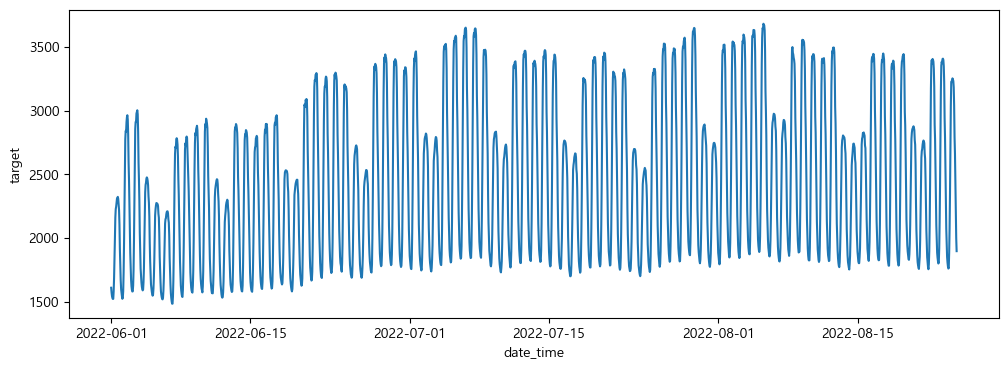

In [7]:
# 전력사용량 패턴
plt.figure(figsize=(12, 4))
train['date_time'] = pd.to_datetime(train['date_time'])
sns.lineplot(data=train, x='date_time', y='target', errorbar=None);

In [8]:
train = pd.merge(train, building_info, on='num', how='inner')
train

num_date_time  num           date_time  temperature  precipitation  \
0         1_20220601 00    1 2022-06-01 00:00:00         18.6            NaN   
1         1_20220601 01    1 2022-06-01 01:00:00         18.0            NaN   
2         1_20220601 02    1 2022-06-01 02:00:00         17.7            NaN   
3         1_20220601 03    1 2022-06-01 03:00:00         16.7            NaN   
4         1_20220601 04    1 2022-06-01 04:00:00         18.4            NaN   
...                 ...  ...                 ...          ...            ...   
203995  100_20220824 19  100 2022-08-24 19:00:00         23.1            NaN   
203996  100_20220824 20  100 2022-08-24 20:00:00         22.4            NaN   
203997  100_20220824 21  100 2022-08-24 21:00:00         21.3            NaN   
203998  100_20220824 22  100 2022-08-24 22:00:00         21.0            NaN   
203999  100_20220824 23  100 2022-08-24 23:00:00         20.7            NaN   

        windspeed  humidity   target    type       area  cooling_area  solar  \
0             0.9      42.0  1085.28    건물기타  110634.00      39570.00    0.0   
1             1.1      45.0  1047.36    건물기타  110634.00      39570.00    0.0   
2             1.5      45.0   974.88    건물기타  110634.00      39570.00    0.0   
3             1.4      48.0   953.76    건물기타  110634.00      39570.00    0.0   
4             2.8      43.0   986.40    건물기타  110634.00      39570.00    0.0   
...           ...       ...      ...     ...        ...           ...    ...   
203995        0.9      86.0   881.04  호텔및리조트   57497.84      40035.23    0.0   
203996        1.3      86.0   798.96  호텔및리조트   57497.84      40035.23    0.0   
203997        1.0      92.0   825.12  호텔및리조트   57497.84      40035.23    0.0   
203998        0.3      94.0   640.08  호텔및리조트   57497.84      40035.23    0.0   
203999        0.1      95.0   540.24  호텔및리조트   57497.84      40035.23    0.0   

        ESS  PCS  
0       0.0  0.0  
1       0.0  0.0  
2       0.0  0.0  
3       0.0  0.0  
4       0.0  0.0  
...     ...  ...  
203995  0.0  0.0  
203996  0.0  0.0  
203997  0.0  0.0  
203998  0.0  0.0  
203999  0.0  0.0  

[204000 rows x 14 columns]

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 1')

<Axes: title={'center': 'Building 1'}, xlabel='date_time', ylabel='target'>

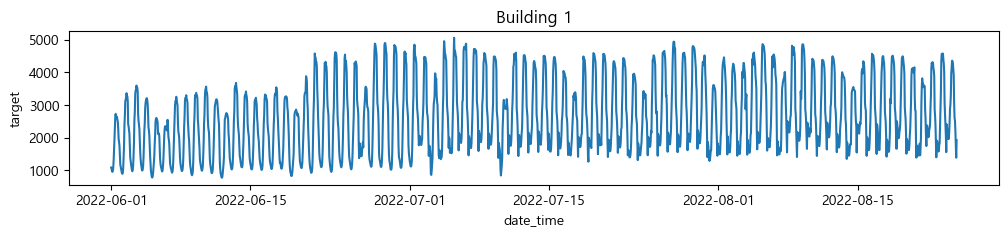

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 2')

<Axes: title={'center': 'Building 2'}, xlabel='date_time', ylabel='target'>

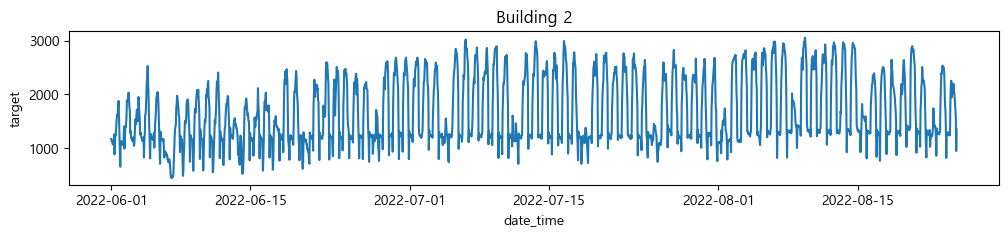

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 3')

<Axes: title={'center': 'Building 3'}, xlabel='date_time', ylabel='target'>

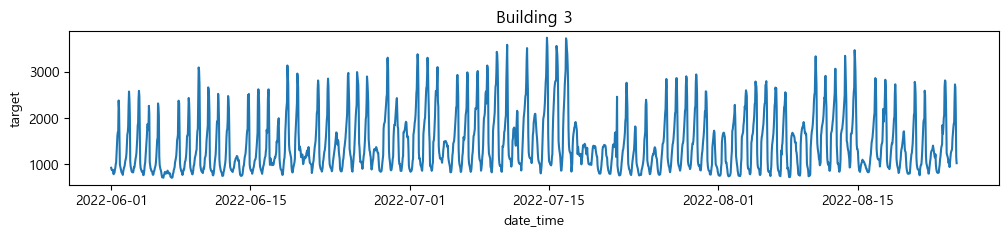

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 4')

<Axes: title={'center': 'Building 4'}, xlabel='date_time', ylabel='target'>

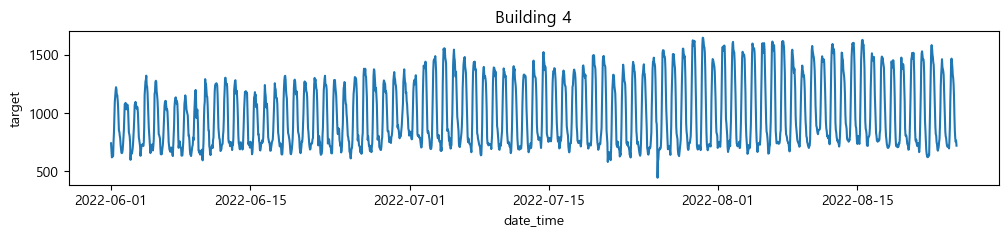

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 5')

<Axes: title={'center': 'Building 5'}, xlabel='date_time', ylabel='target'>

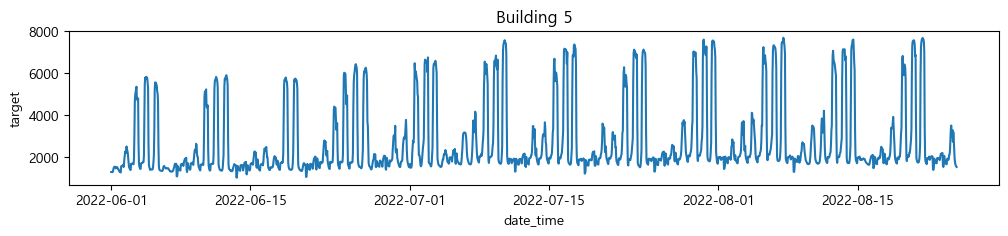

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 6')

<Axes: title={'center': 'Building 6'}, xlabel='date_time', ylabel='target'>

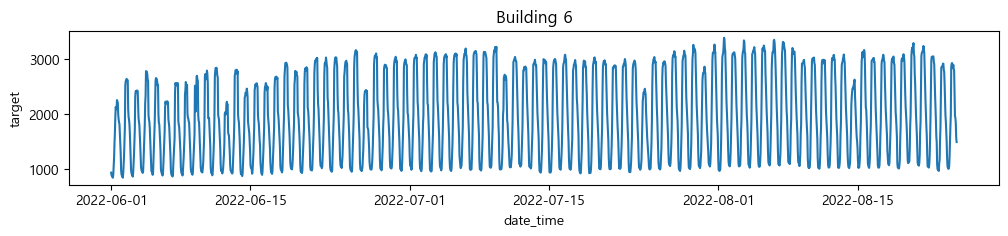

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 7')

<Axes: title={'center': 'Building 7'}, xlabel='date_time', ylabel='target'>

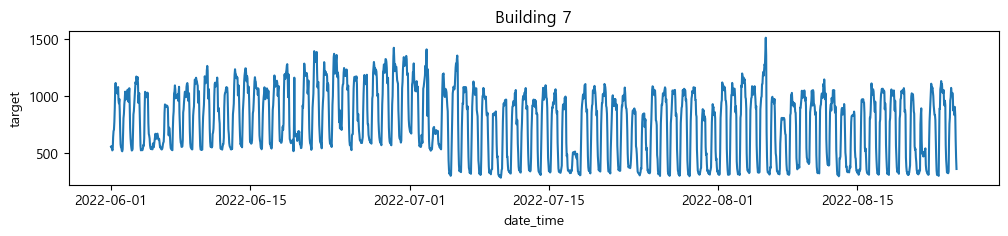

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 8')

<Axes: title={'center': 'Building 8'}, xlabel='date_time', ylabel='target'>

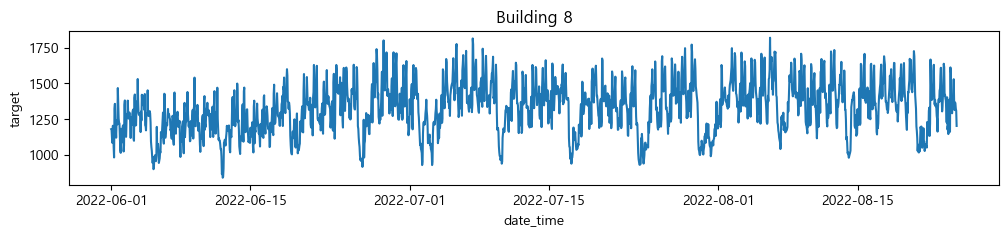

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 9')

<Axes: title={'center': 'Building 9'}, xlabel='date_time', ylabel='target'>

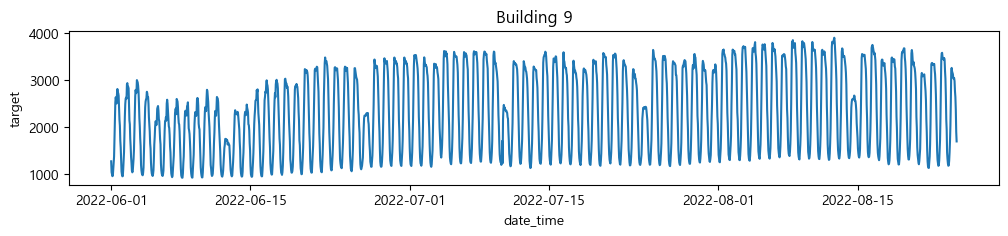

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 10')

<Axes: title={'center': 'Building 10'}, xlabel='date_time', ylabel='target'>

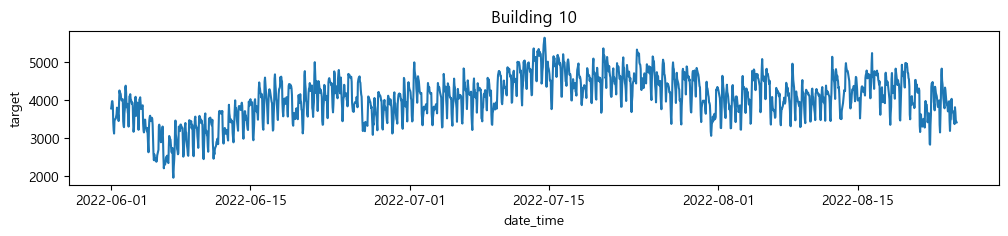

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 11')

<Axes: title={'center': 'Building 11'}, xlabel='date_time', ylabel='target'>

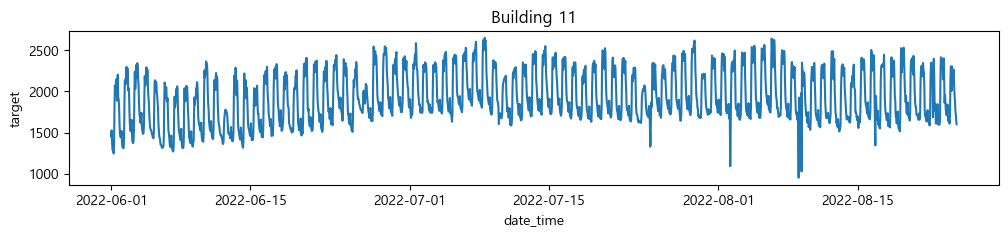

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 12')

<Axes: title={'center': 'Building 12'}, xlabel='date_time', ylabel='target'>

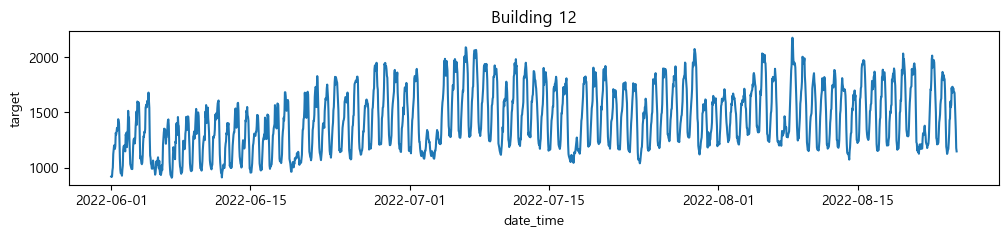

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 13')

<Axes: title={'center': 'Building 13'}, xlabel='date_time', ylabel='target'>

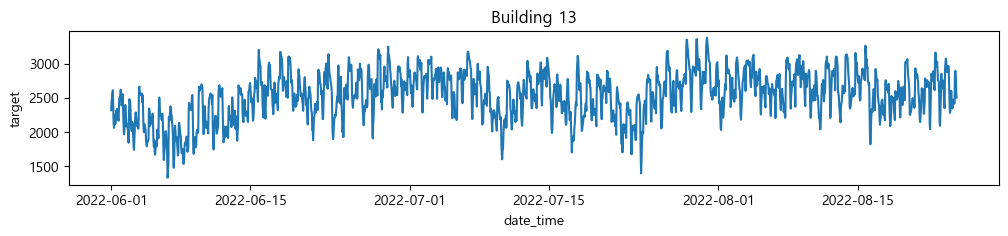

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 14')

<Axes: title={'center': 'Building 14'}, xlabel='date_time', ylabel='target'>

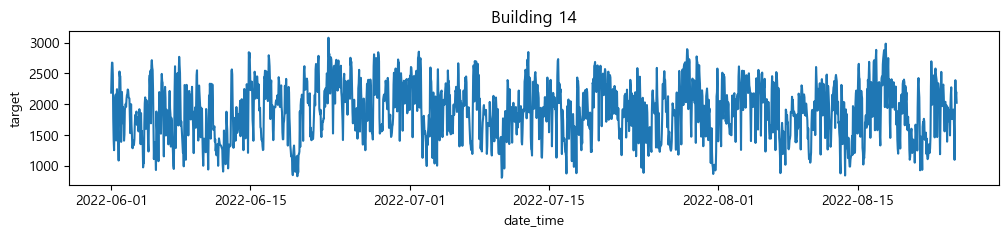

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 15')

<Axes: title={'center': 'Building 15'}, xlabel='date_time', ylabel='target'>

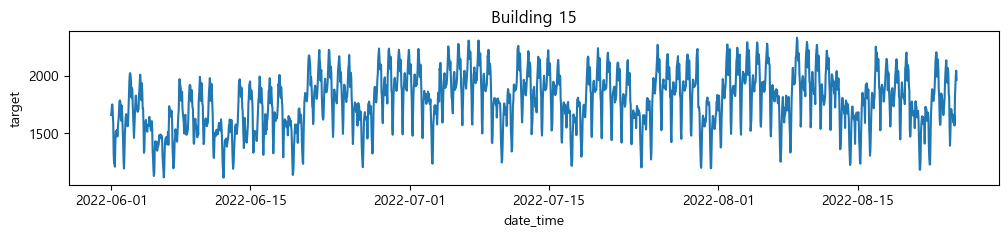

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 16')

<Axes: title={'center': 'Building 16'}, xlabel='date_time', ylabel='target'>

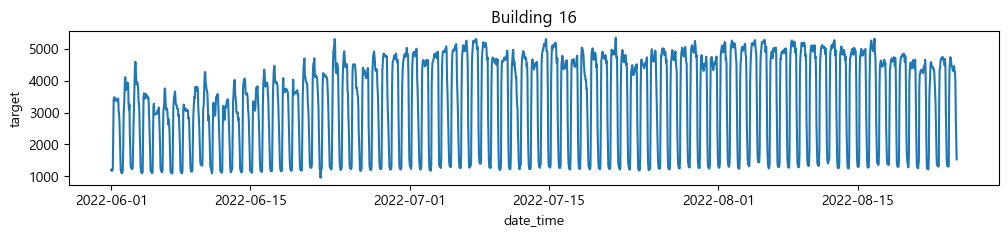

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 17')

<Axes: title={'center': 'Building 17'}, xlabel='date_time', ylabel='target'>

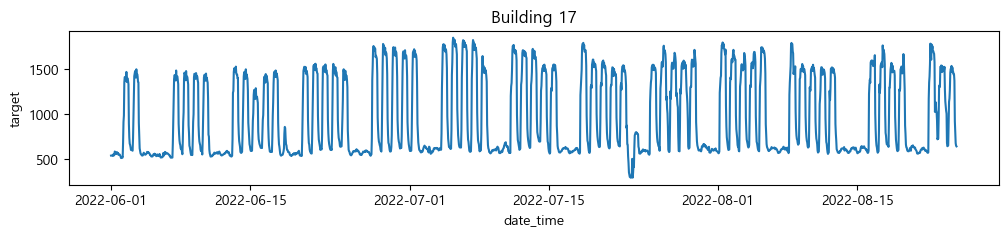

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 18')

<Axes: title={'center': 'Building 18'}, xlabel='date_time', ylabel='target'>

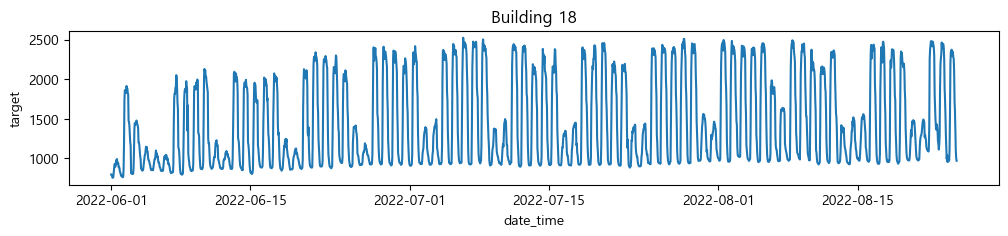

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 19')

<Axes: title={'center': 'Building 19'}, xlabel='date_time', ylabel='target'>

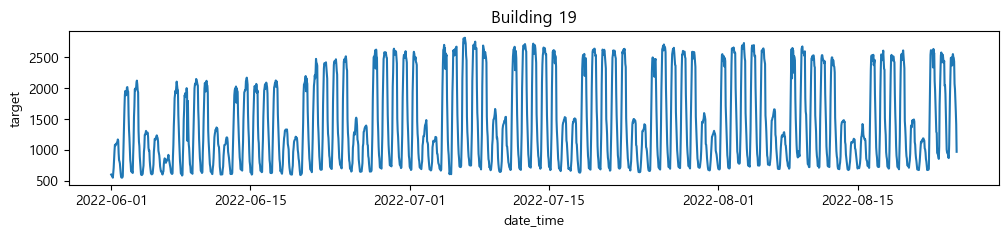

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 20')

<Axes: title={'center': 'Building 20'}, xlabel='date_time', ylabel='target'>

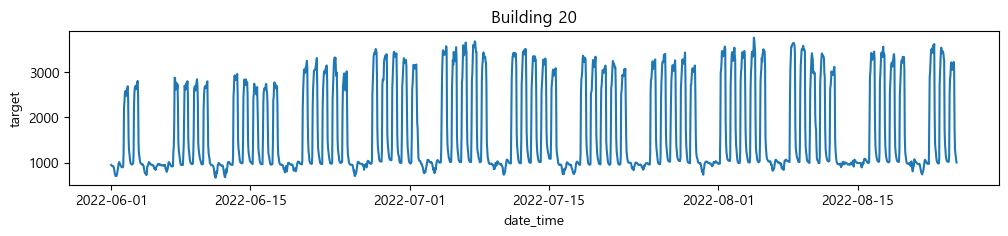

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 21')

<Axes: title={'center': 'Building 21'}, xlabel='date_time', ylabel='target'>

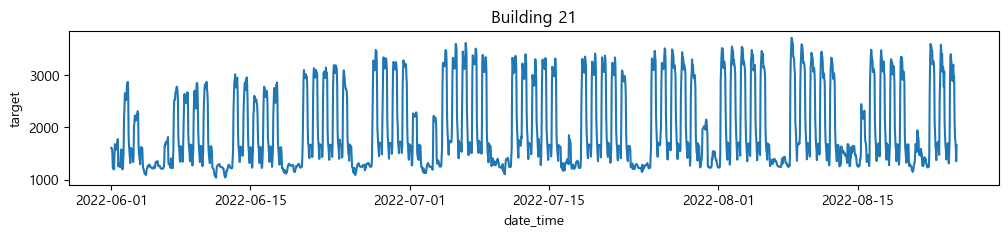

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 22')

<Axes: title={'center': 'Building 22'}, xlabel='date_time', ylabel='target'>

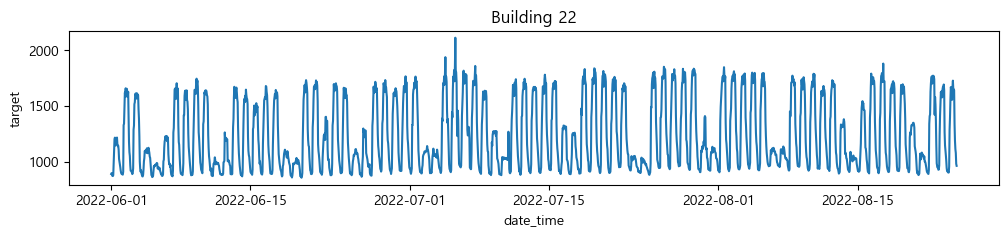

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 23')

<Axes: title={'center': 'Building 23'}, xlabel='date_time', ylabel='target'>

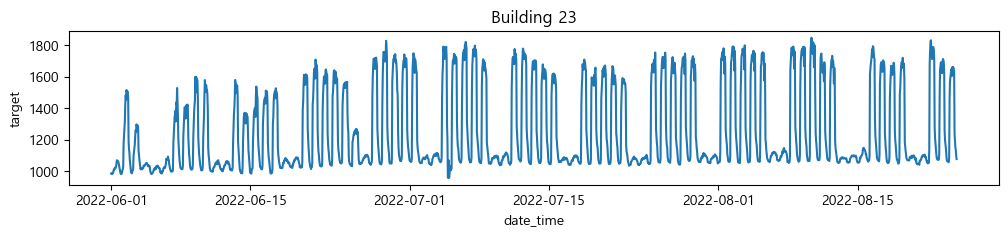

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 24')

<Axes: title={'center': 'Building 24'}, xlabel='date_time', ylabel='target'>

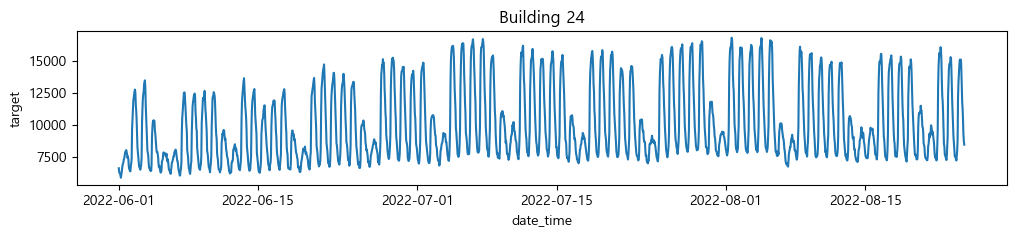

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 25')

<Axes: title={'center': 'Building 25'}, xlabel='date_time', ylabel='target'>

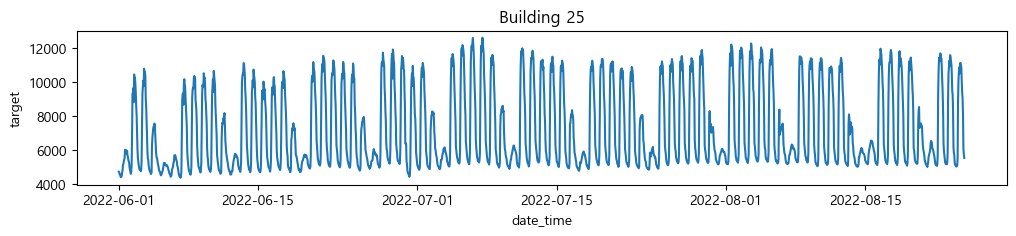

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 26')

<Axes: title={'center': 'Building 26'}, xlabel='date_time', ylabel='target'>

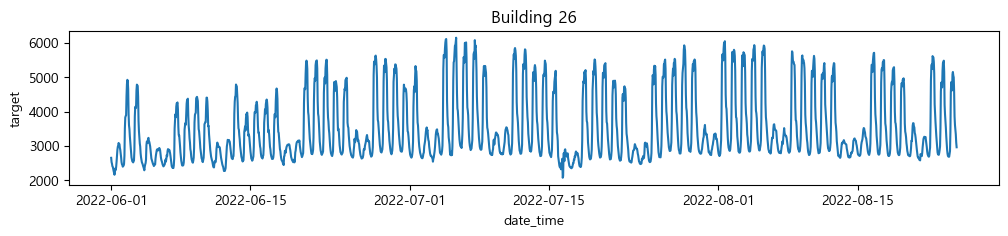

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 27')

<Axes: title={'center': 'Building 27'}, xlabel='date_time', ylabel='target'>

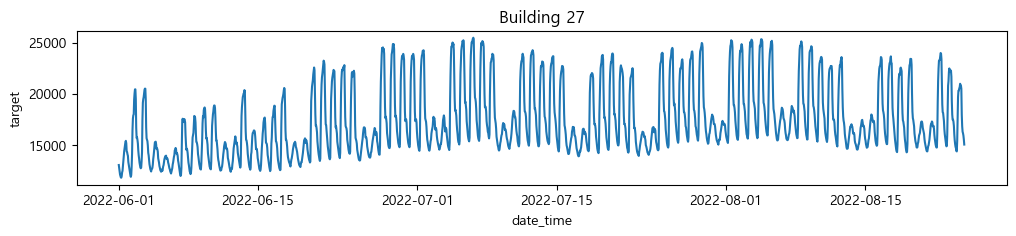

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 28')

<Axes: title={'center': 'Building 28'}, xlabel='date_time', ylabel='target'>

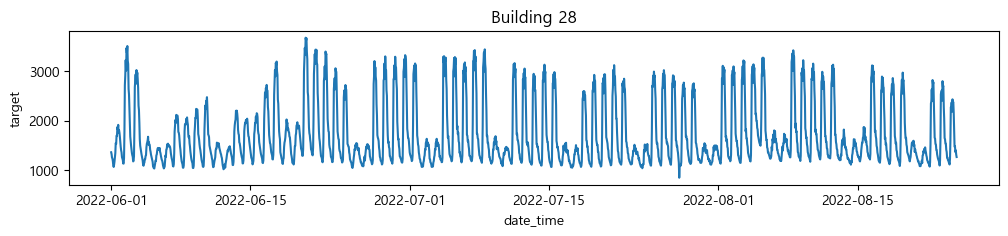

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 29')

<Axes: title={'center': 'Building 29'}, xlabel='date_time', ylabel='target'>

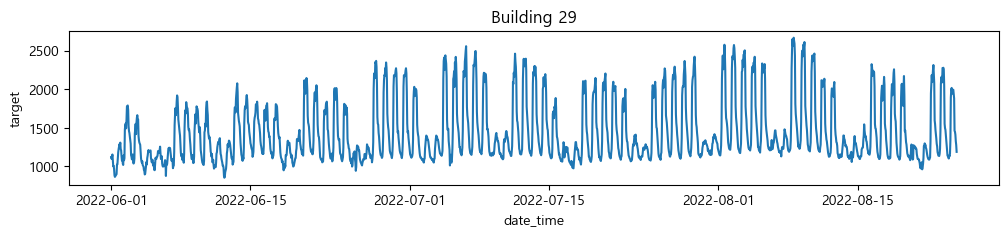

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 30')

<Axes: title={'center': 'Building 30'}, xlabel='date_time', ylabel='target'>

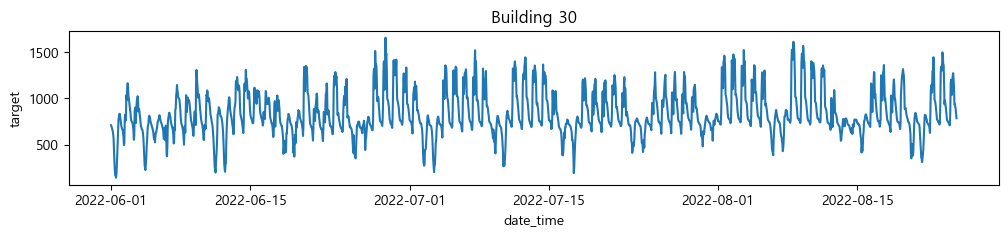

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 31')

<Axes: title={'center': 'Building 31'}, xlabel='date_time', ylabel='target'>

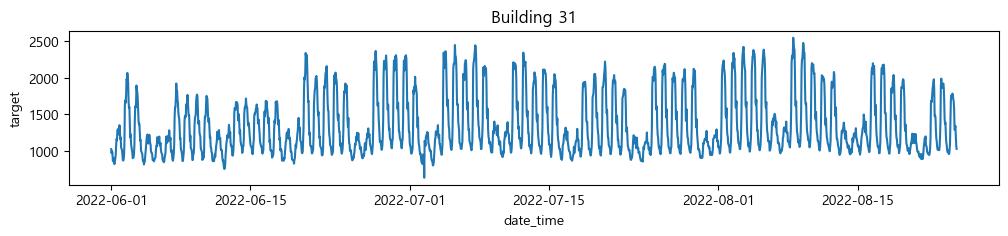

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 32')

<Axes: title={'center': 'Building 32'}, xlabel='date_time', ylabel='target'>

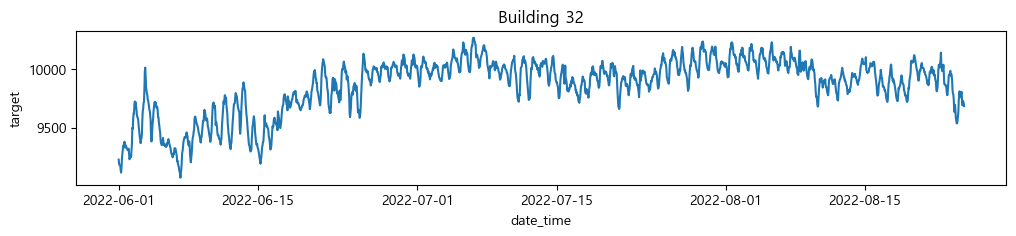

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 33')

<Axes: title={'center': 'Building 33'}, xlabel='date_time', ylabel='target'>

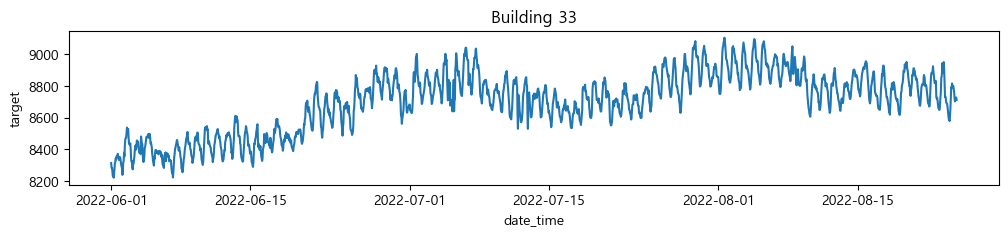

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 34')

<Axes: title={'center': 'Building 34'}, xlabel='date_time', ylabel='target'>

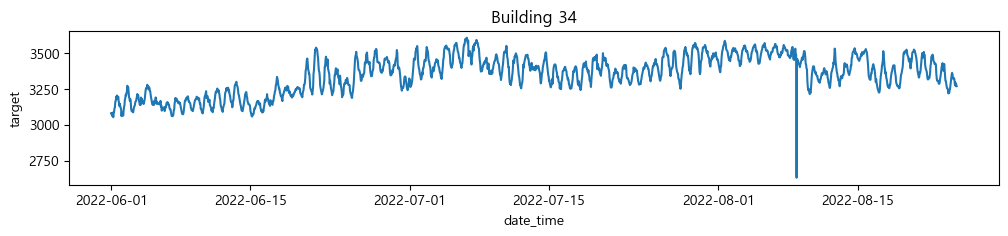

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 35')

<Axes: title={'center': 'Building 35'}, xlabel='date_time', ylabel='target'>

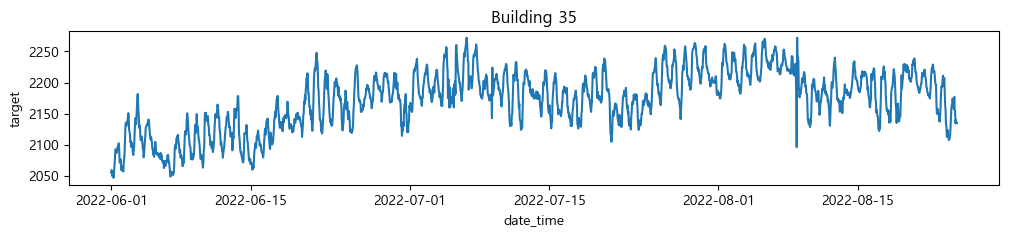

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 36')

<Axes: title={'center': 'Building 36'}, xlabel='date_time', ylabel='target'>

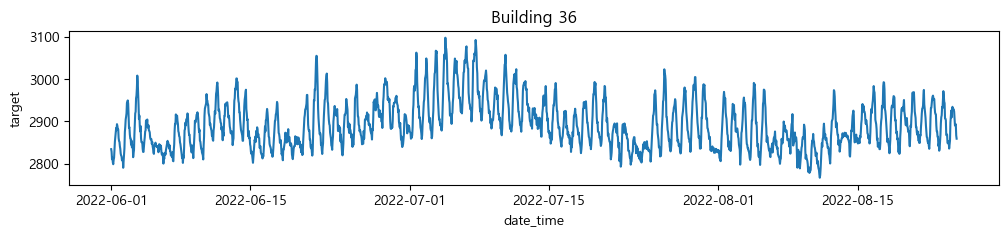

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 37')

<Axes: title={'center': 'Building 37'}, xlabel='date_time', ylabel='target'>

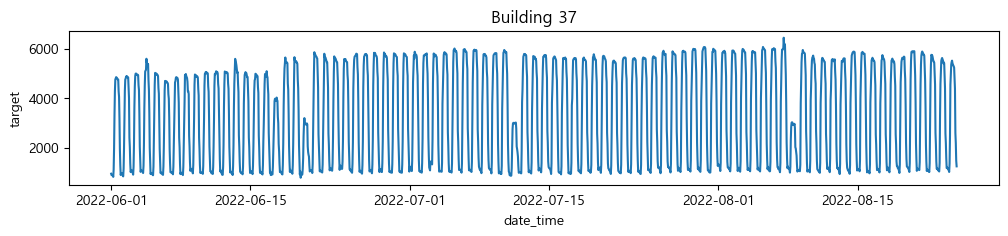

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 38')

<Axes: title={'center': 'Building 38'}, xlabel='date_time', ylabel='target'>

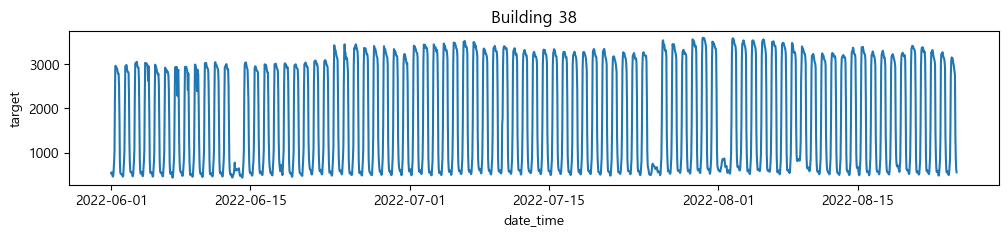

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 39')

<Axes: title={'center': 'Building 39'}, xlabel='date_time', ylabel='target'>

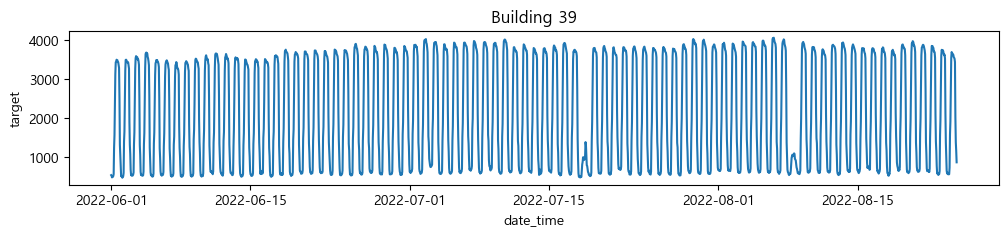

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 40')

<Axes: title={'center': 'Building 40'}, xlabel='date_time', ylabel='target'>

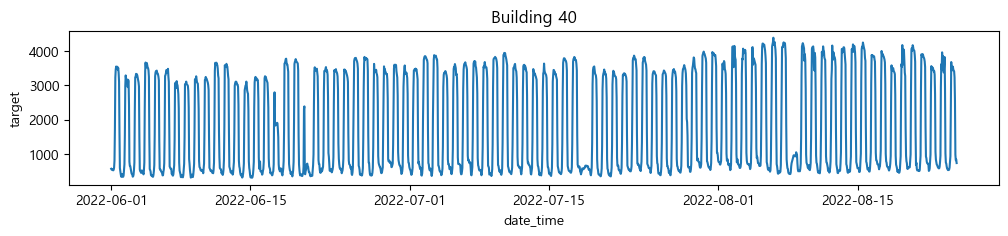

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 41')

<Axes: title={'center': 'Building 41'}, xlabel='date_time', ylabel='target'>

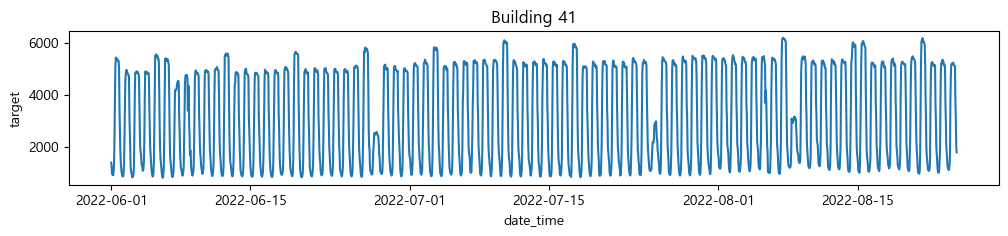

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 42')

<Axes: title={'center': 'Building 42'}, xlabel='date_time', ylabel='target'>

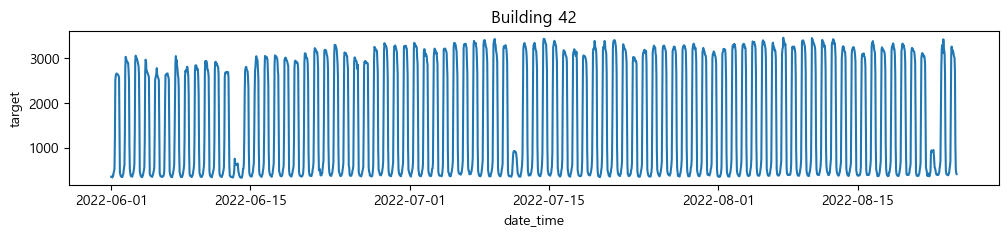

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 43')

<Axes: title={'center': 'Building 43'}, xlabel='date_time', ylabel='target'>

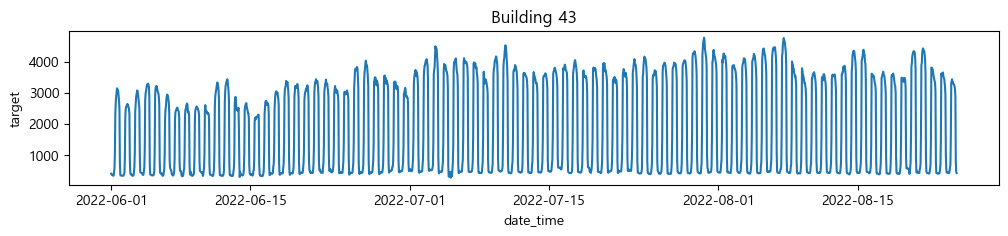

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 44')

<Axes: title={'center': 'Building 44'}, xlabel='date_time', ylabel='target'>

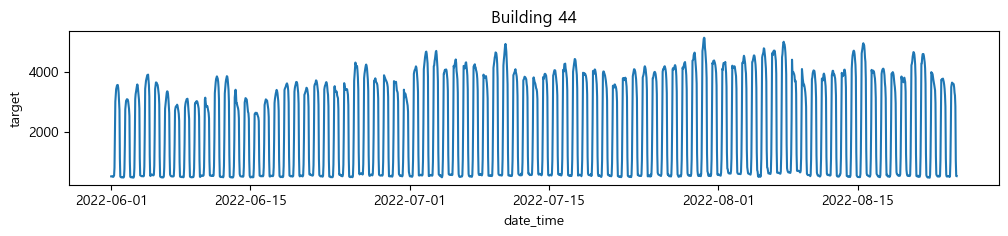

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 45')

<Axes: title={'center': 'Building 45'}, xlabel='date_time', ylabel='target'>

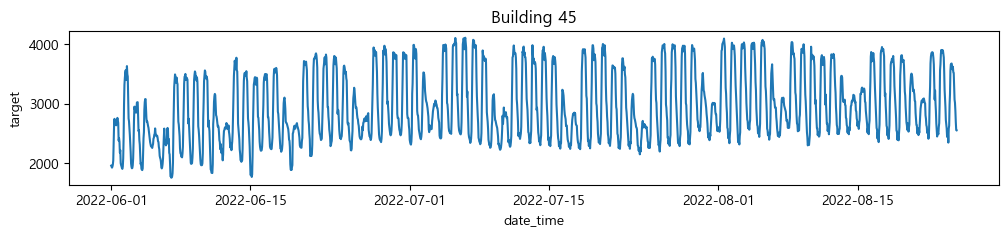

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 46')

<Axes: title={'center': 'Building 46'}, xlabel='date_time', ylabel='target'>

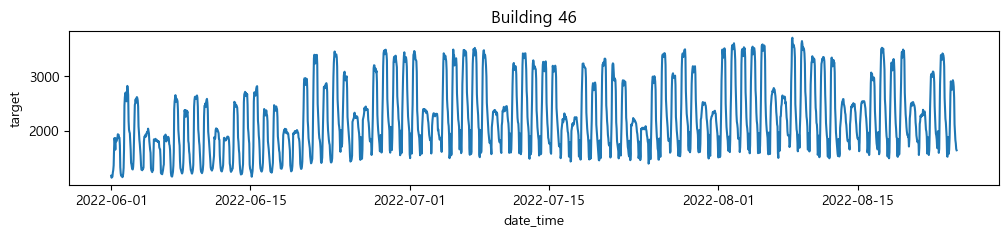

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 47')

<Axes: title={'center': 'Building 47'}, xlabel='date_time', ylabel='target'>

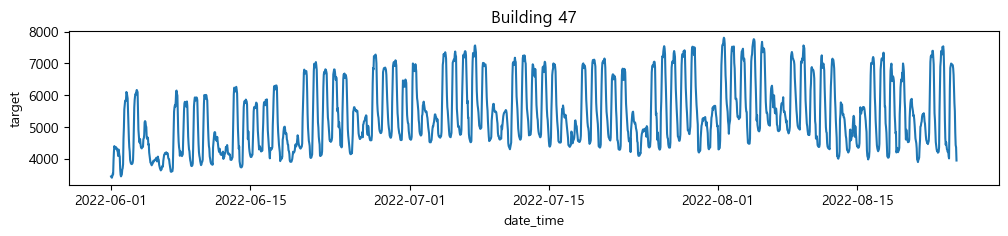

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 48')

<Axes: title={'center': 'Building 48'}, xlabel='date_time', ylabel='target'>

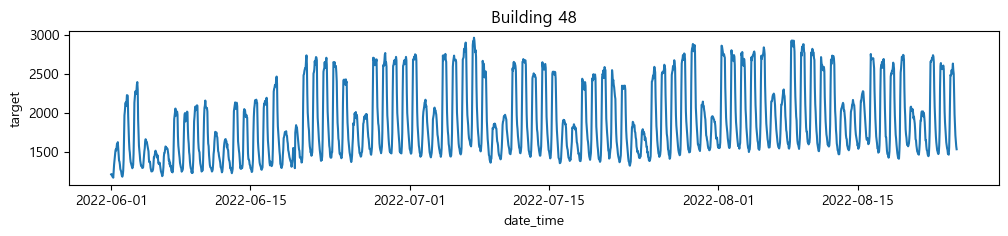

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 49')

<Axes: title={'center': 'Building 49'}, xlabel='date_time', ylabel='target'>

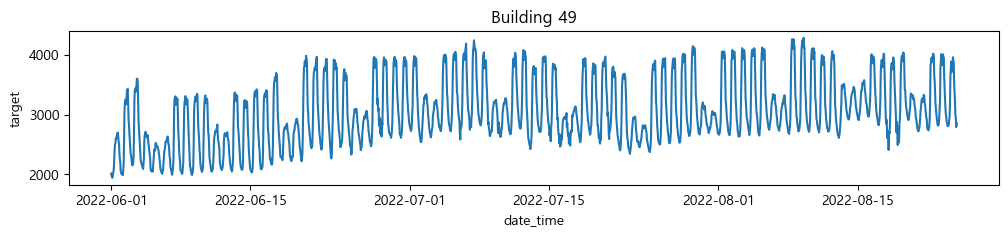

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 50')

<Axes: title={'center': 'Building 50'}, xlabel='date_time', ylabel='target'>

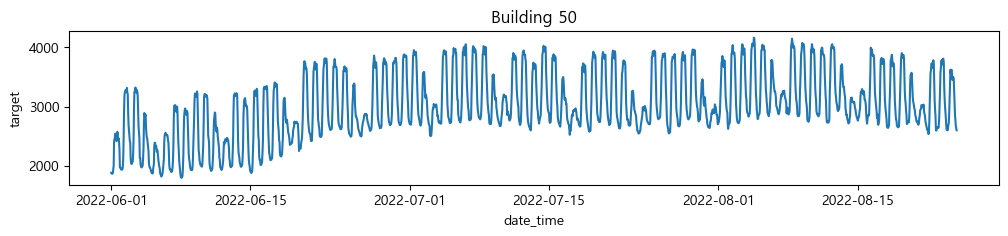

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 51')

<Axes: title={'center': 'Building 51'}, xlabel='date_time', ylabel='target'>

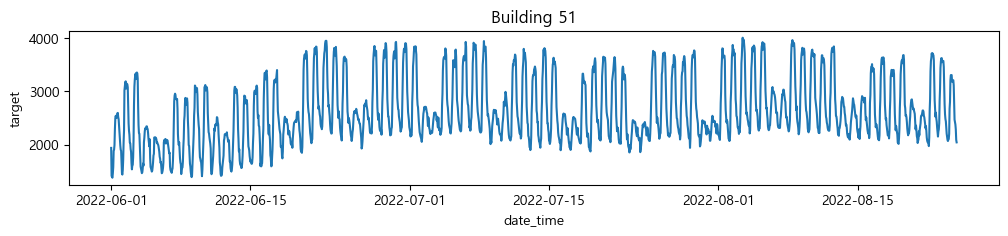

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 52')

<Axes: title={'center': 'Building 52'}, xlabel='date_time', ylabel='target'>

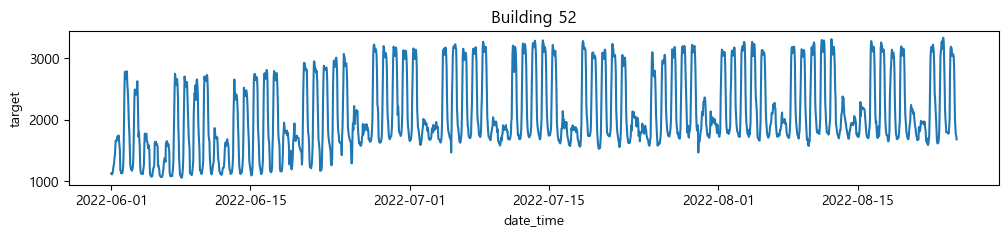

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 53')

<Axes: title={'center': 'Building 53'}, xlabel='date_time', ylabel='target'>

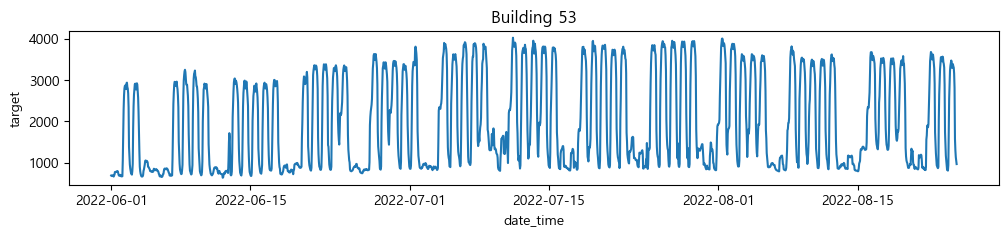

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 54')

<Axes: title={'center': 'Building 54'}, xlabel='date_time', ylabel='target'>

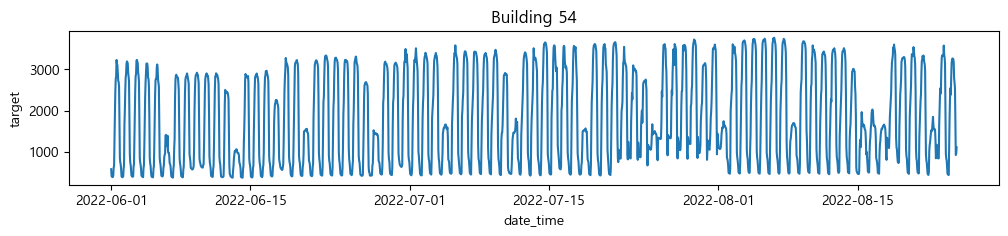

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 55')

<Axes: title={'center': 'Building 55'}, xlabel='date_time', ylabel='target'>

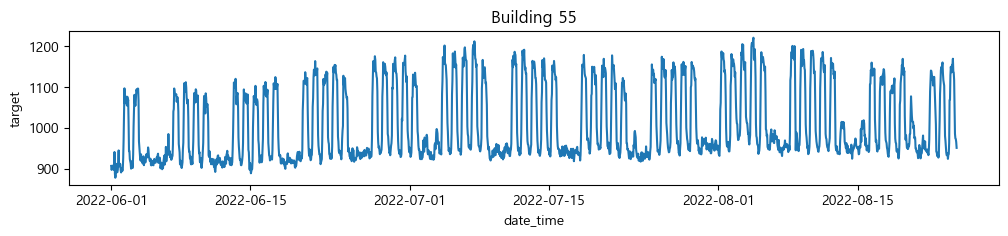

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 56')

<Axes: title={'center': 'Building 56'}, xlabel='date_time', ylabel='target'>

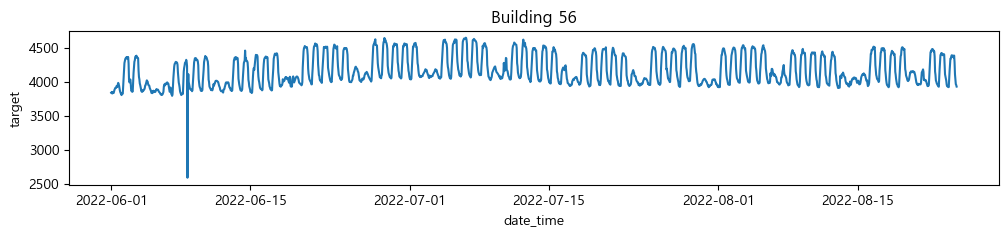

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 57')

<Axes: title={'center': 'Building 57'}, xlabel='date_time', ylabel='target'>

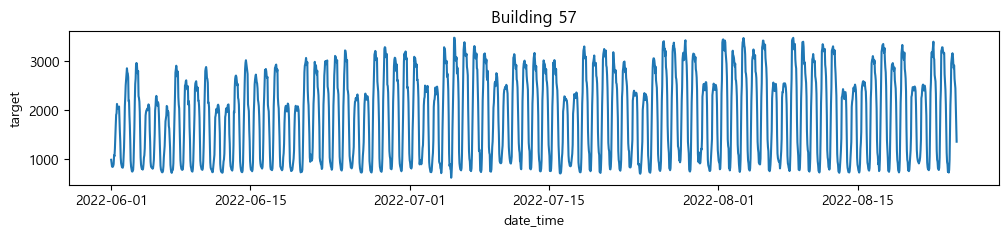

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 58')

<Axes: title={'center': 'Building 58'}, xlabel='date_time', ylabel='target'>

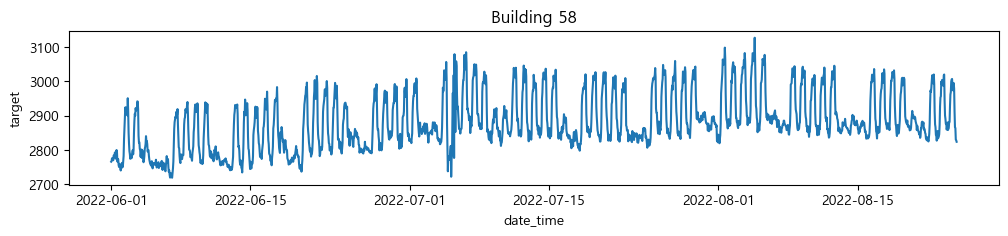

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 59')

<Axes: title={'center': 'Building 59'}, xlabel='date_time', ylabel='target'>

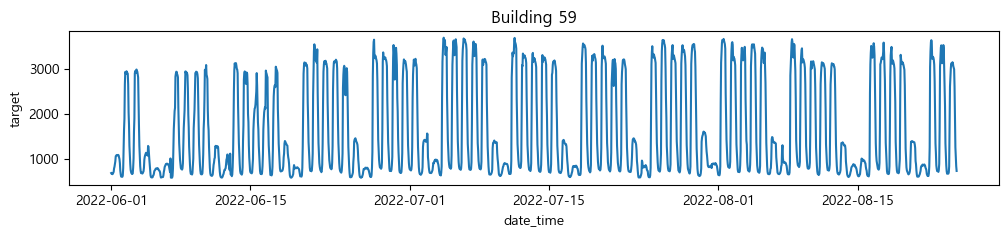

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 60')

<Axes: title={'center': 'Building 60'}, xlabel='date_time', ylabel='target'>

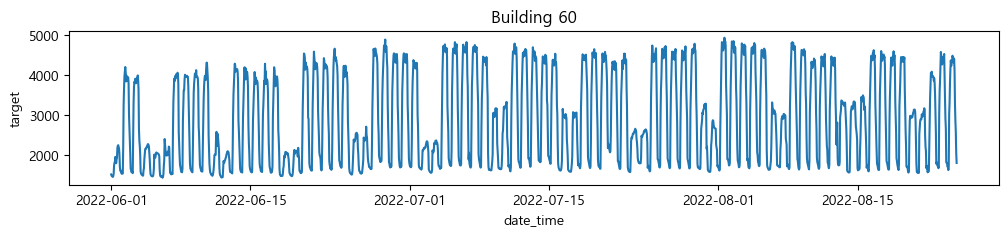

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 61')

<Axes: title={'center': 'Building 61'}, xlabel='date_time', ylabel='target'>

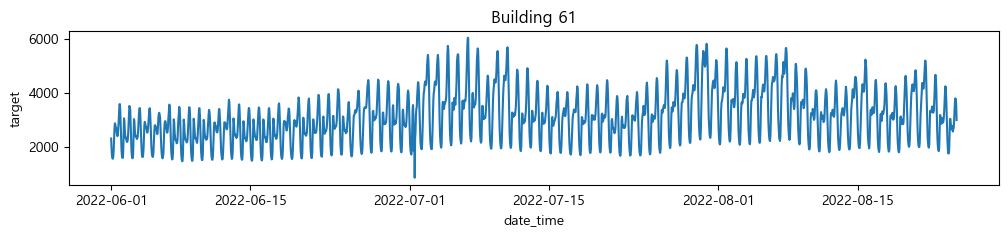

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 62')

<Axes: title={'center': 'Building 62'}, xlabel='date_time', ylabel='target'>

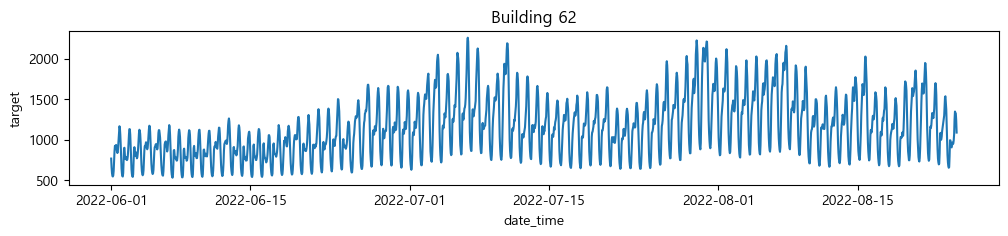

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 63')

<Axes: title={'center': 'Building 63'}, xlabel='date_time', ylabel='target'>

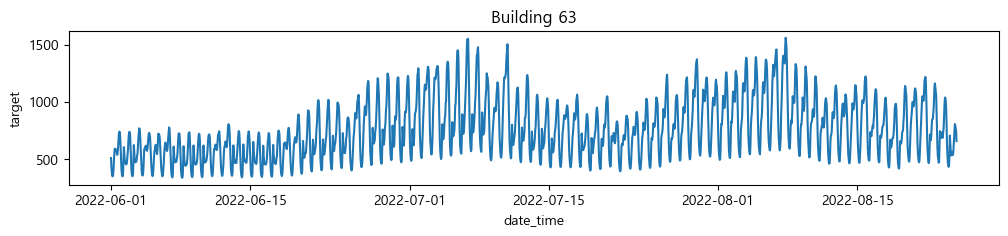

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 64')

<Axes: title={'center': 'Building 64'}, xlabel='date_time', ylabel='target'>

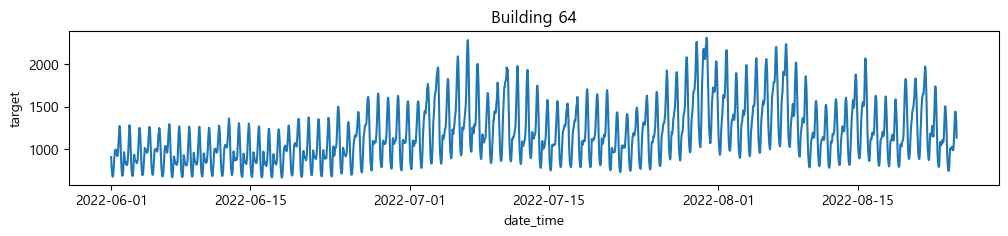

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 65')

<Axes: title={'center': 'Building 65'}, xlabel='date_time', ylabel='target'>

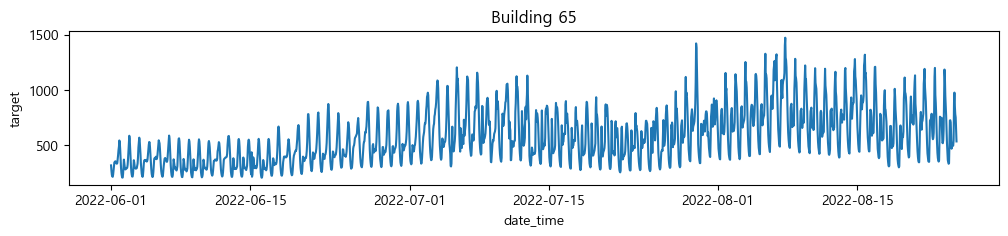

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 66')

<Axes: title={'center': 'Building 66'}, xlabel='date_time', ylabel='target'>

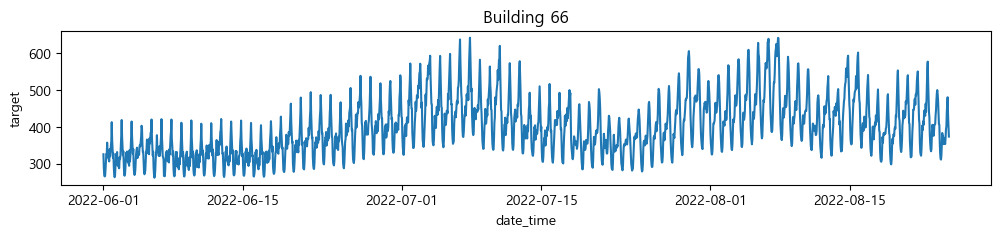

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 67')

<Axes: title={'center': 'Building 67'}, xlabel='date_time', ylabel='target'>

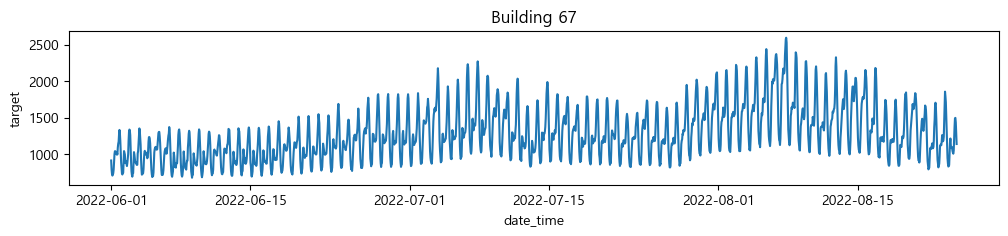

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 68')

<Axes: title={'center': 'Building 68'}, xlabel='date_time', ylabel='target'>

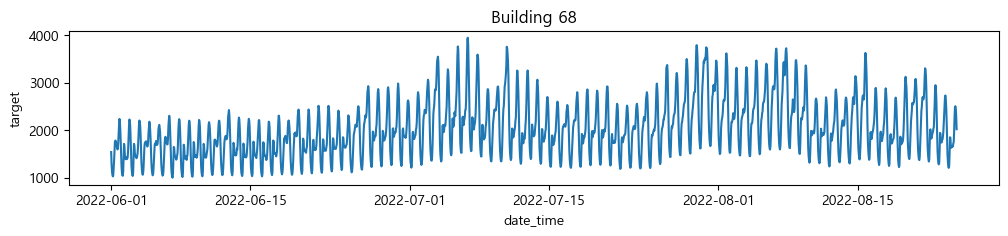

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 69')

<Axes: title={'center': 'Building 69'}, xlabel='date_time', ylabel='target'>

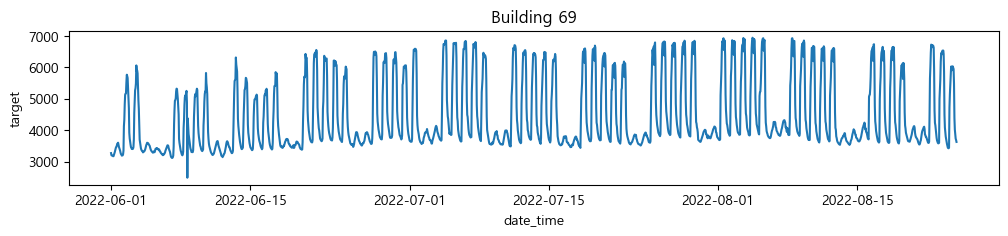

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 70')

<Axes: title={'center': 'Building 70'}, xlabel='date_time', ylabel='target'>

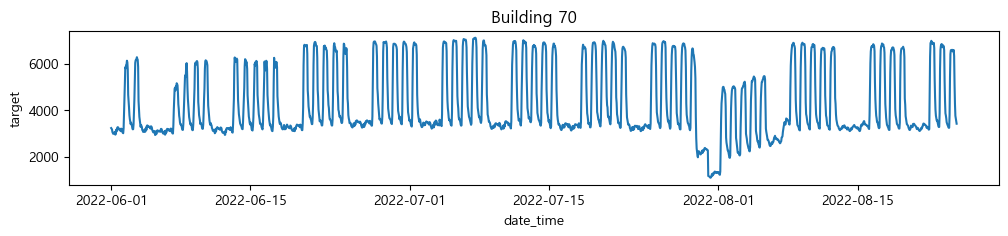

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 71')

<Axes: title={'center': 'Building 71'}, xlabel='date_time', ylabel='target'>

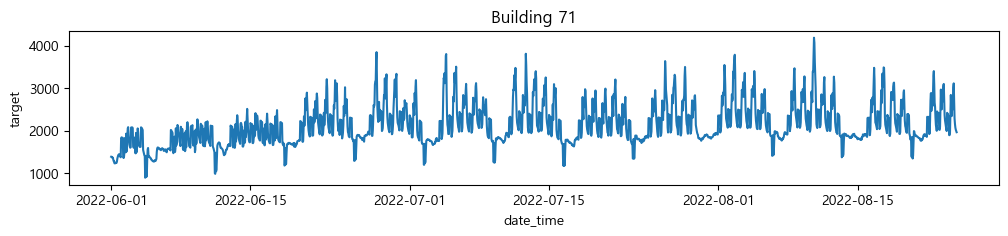

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 72')

<Axes: title={'center': 'Building 72'}, xlabel='date_time', ylabel='target'>

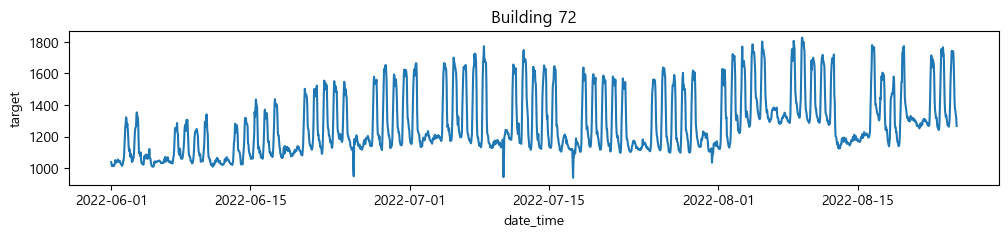

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 73')

<Axes: title={'center': 'Building 73'}, xlabel='date_time', ylabel='target'>

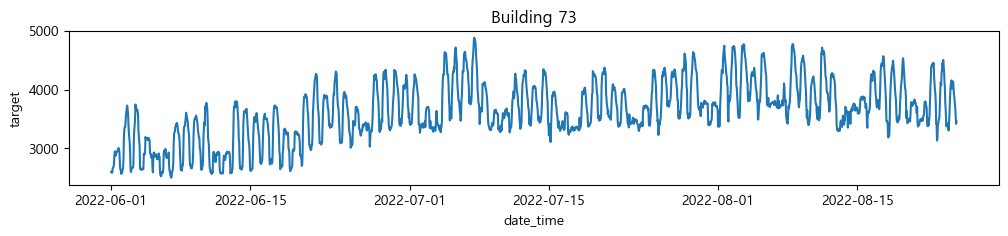

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 74')

<Axes: title={'center': 'Building 74'}, xlabel='date_time', ylabel='target'>

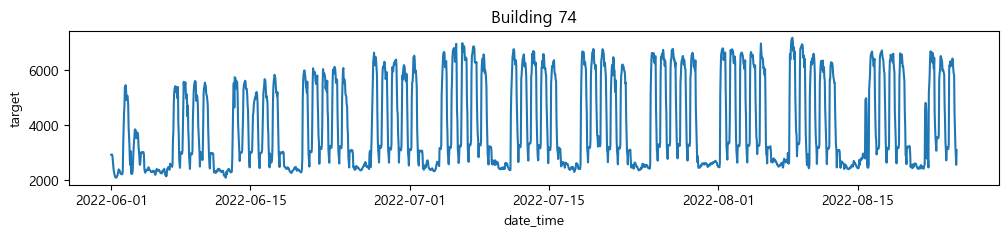

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 75')

<Axes: title={'center': 'Building 75'}, xlabel='date_time', ylabel='target'>

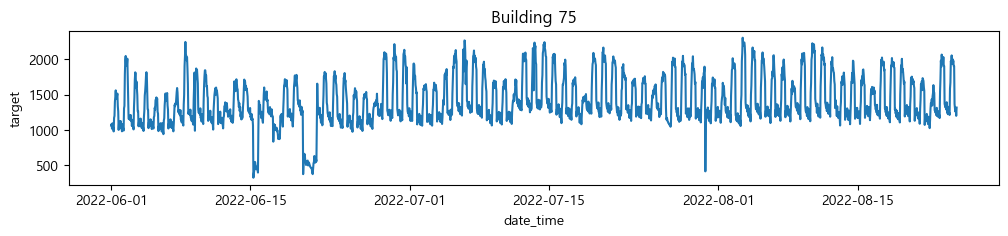

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 76')

<Axes: title={'center': 'Building 76'}, xlabel='date_time', ylabel='target'>

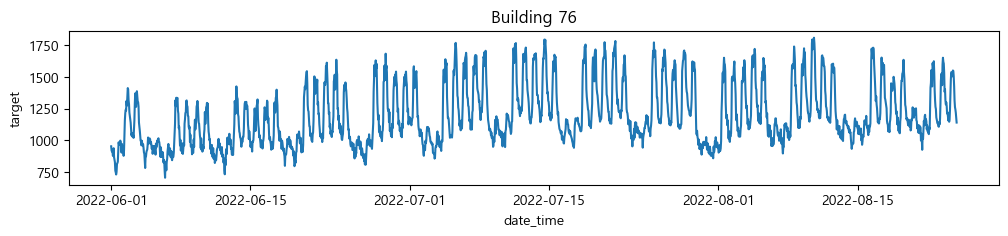

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 77')

<Axes: title={'center': 'Building 77'}, xlabel='date_time', ylabel='target'>

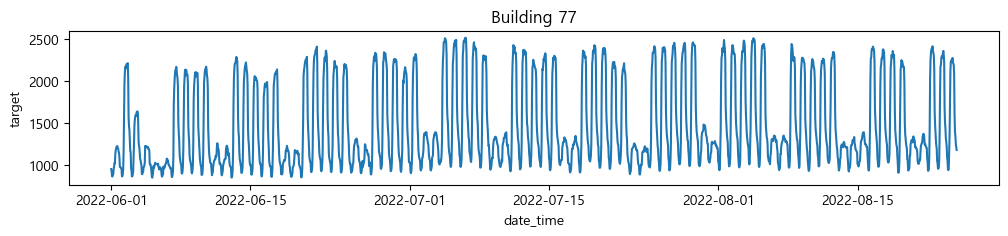

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 78')

<Axes: title={'center': 'Building 78'}, xlabel='date_time', ylabel='target'>

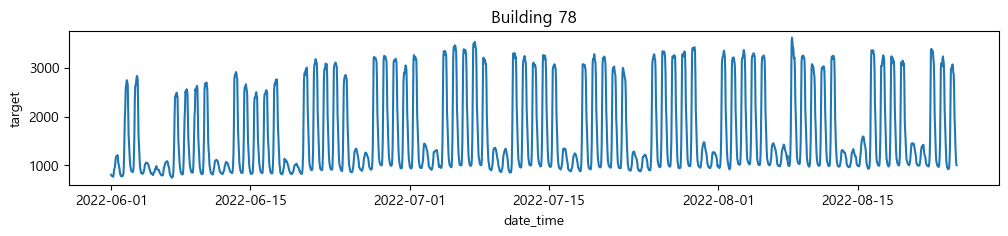

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 79')

<Axes: title={'center': 'Building 79'}, xlabel='date_time', ylabel='target'>

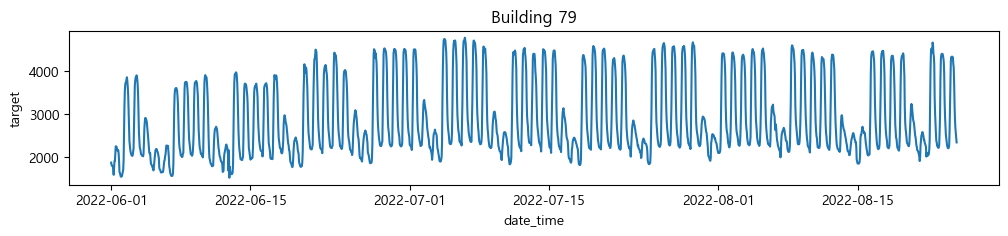

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 80')

<Axes: title={'center': 'Building 80'}, xlabel='date_time', ylabel='target'>

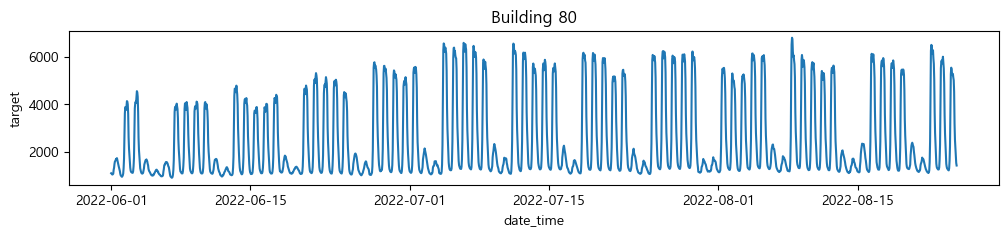

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 81')

<Axes: title={'center': 'Building 81'}, xlabel='date_time', ylabel='target'>

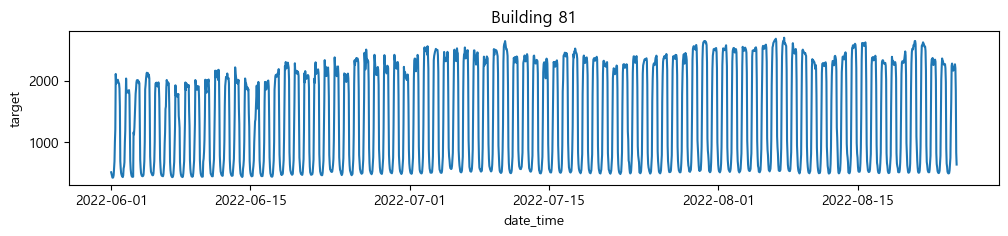

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 82')

<Axes: title={'center': 'Building 82'}, xlabel='date_time', ylabel='target'>

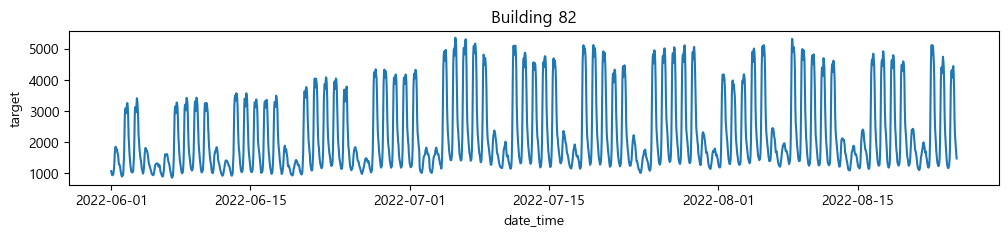

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 83')

<Axes: title={'center': 'Building 83'}, xlabel='date_time', ylabel='target'>

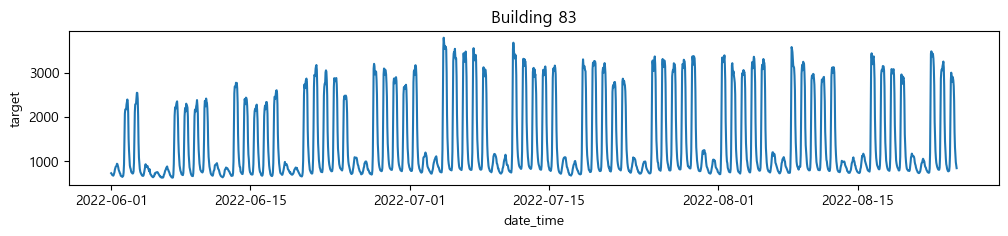

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 84')

<Axes: title={'center': 'Building 84'}, xlabel='date_time', ylabel='target'>

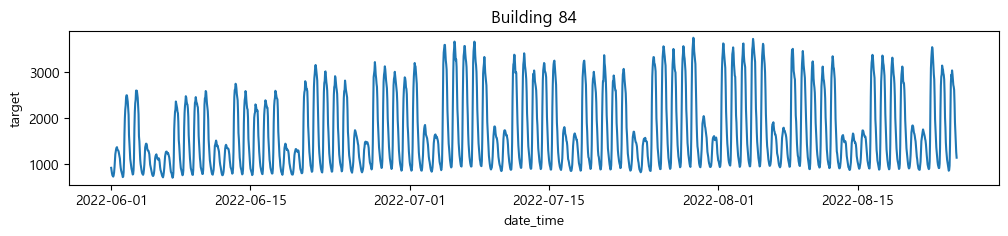

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 85')

<Axes: title={'center': 'Building 85'}, xlabel='date_time', ylabel='target'>

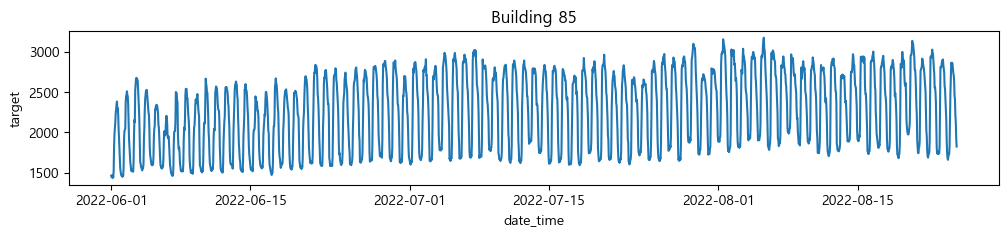

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 86')

<Axes: title={'center': 'Building 86'}, xlabel='date_time', ylabel='target'>

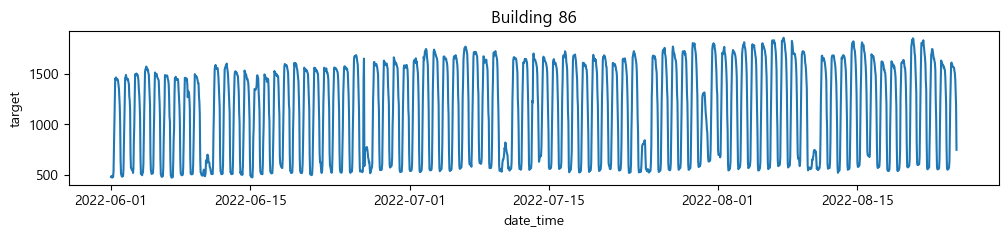

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 87')

<Axes: title={'center': 'Building 87'}, xlabel='date_time', ylabel='target'>

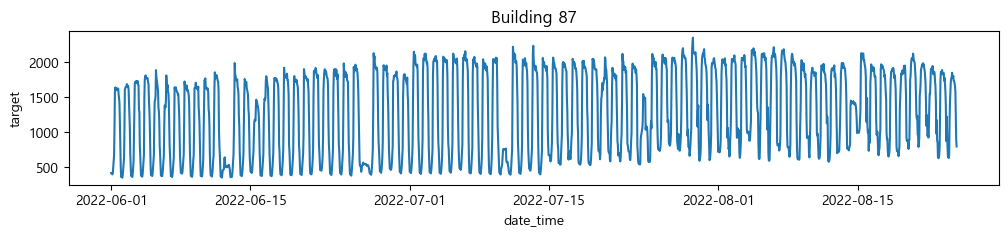

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 88')

<Axes: title={'center': 'Building 88'}, xlabel='date_time', ylabel='target'>

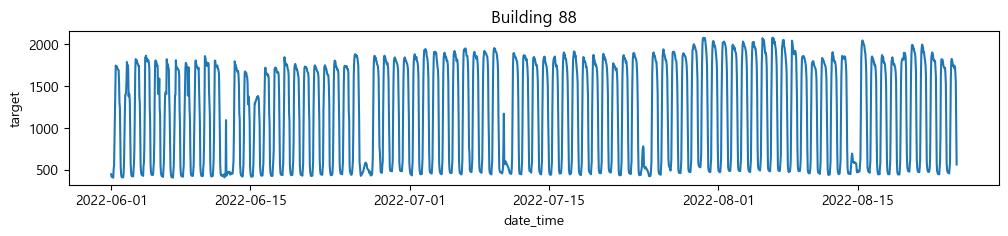

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 89')

<Axes: title={'center': 'Building 89'}, xlabel='date_time', ylabel='target'>

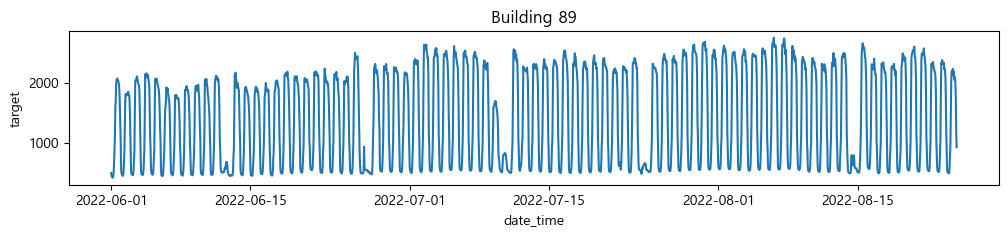

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 90')

<Axes: title={'center': 'Building 90'}, xlabel='date_time', ylabel='target'>

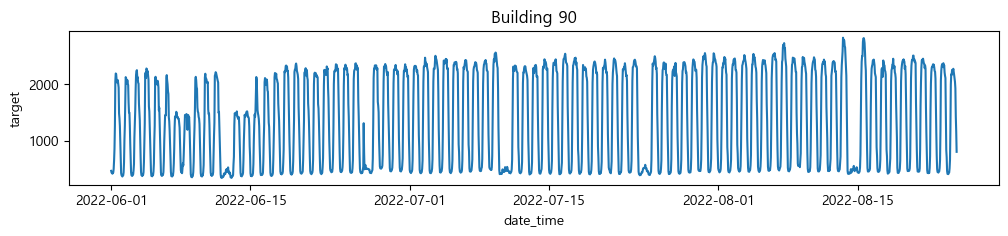

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 91')

<Axes: title={'center': 'Building 91'}, xlabel='date_time', ylabel='target'>

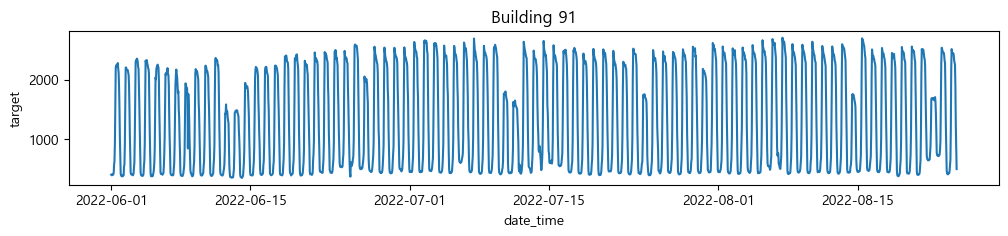

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 92')

<Axes: title={'center': 'Building 92'}, xlabel='date_time', ylabel='target'>

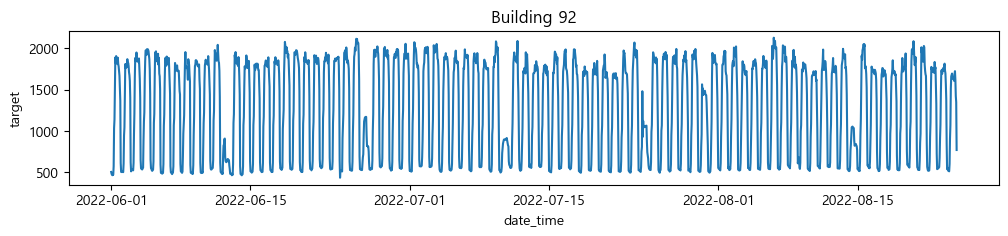

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 93')

<Axes: title={'center': 'Building 93'}, xlabel='date_time', ylabel='target'>

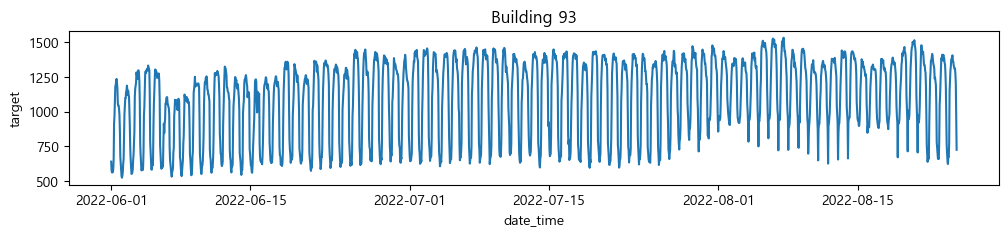

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 94')

<Axes: title={'center': 'Building 94'}, xlabel='date_time', ylabel='target'>

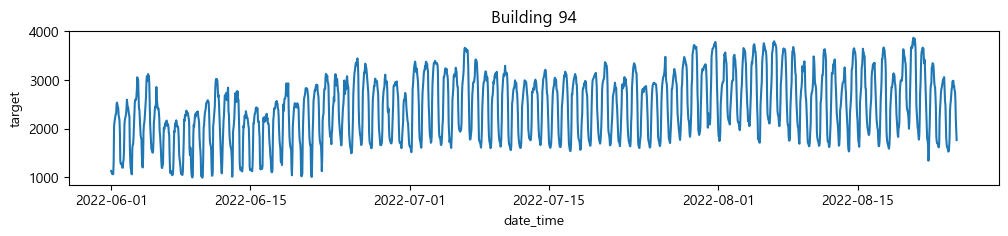

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 95')

<Axes: title={'center': 'Building 95'}, xlabel='date_time', ylabel='target'>

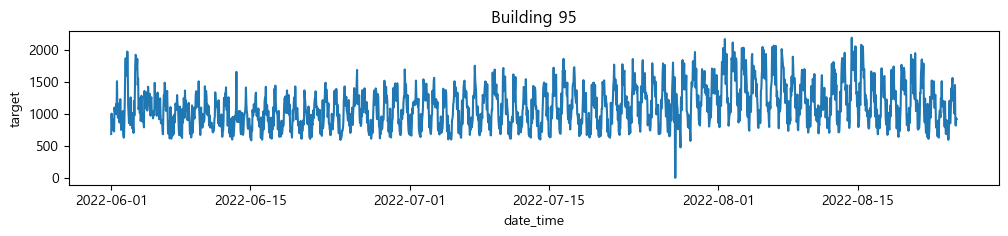

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 96')

<Axes: title={'center': 'Building 96'}, xlabel='date_time', ylabel='target'>

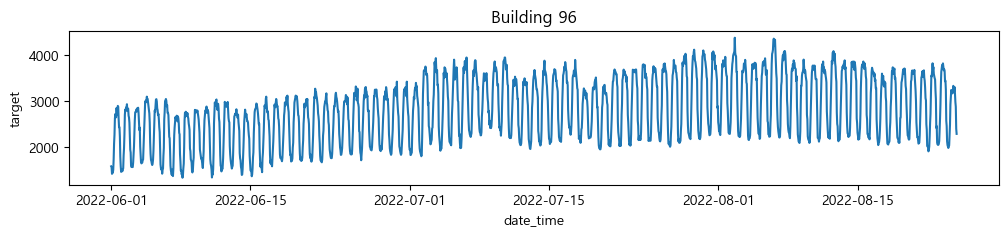

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 97')

<Axes: title={'center': 'Building 97'}, xlabel='date_time', ylabel='target'>

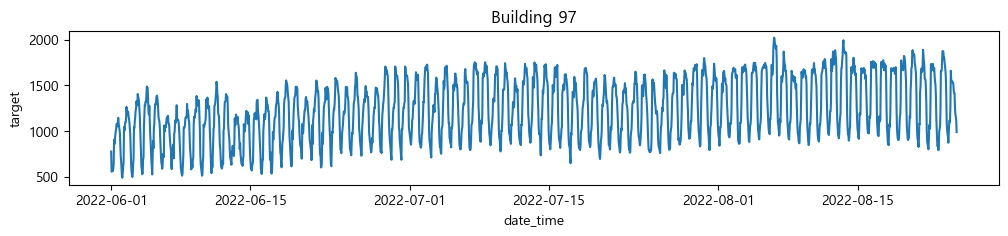

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 98')

<Axes: title={'center': 'Building 98'}, xlabel='date_time', ylabel='target'>

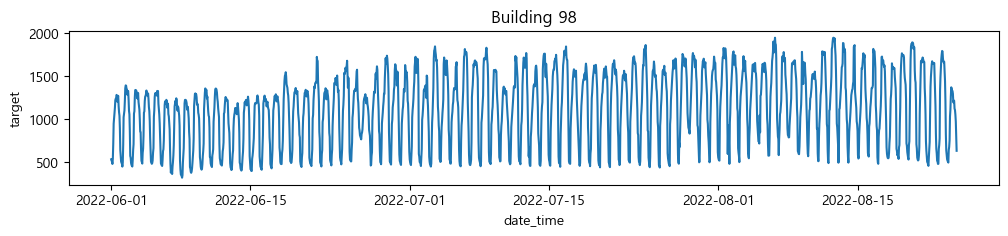

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 99')

<Axes: title={'center': 'Building 99'}, xlabel='date_time', ylabel='target'>

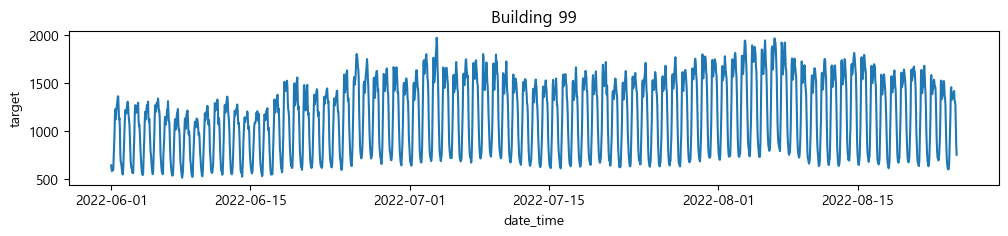

<Figure size 1200x200 with 0 Axes>

Text(0.5, 1.0, 'Building 100')

<Axes: title={'center': 'Building 100'}, xlabel='date_time', ylabel='target'>

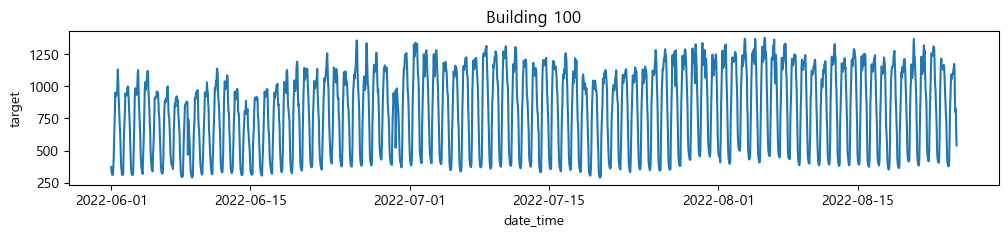

''

In [9]:
# 건물 유형별로 전력사용량 패턴 보기
# for btype in train.type.unique():
#     plt.figure(figsize=(12, 2))
#     plt.title(btype)
#     b = train[train.type == btype]
#     sns.lineplot(data=b, x="date_time", y='target', errorbar=None)
#     plt.show()

# 건물별로 전력사용량 패턴 보기
for bn in train.num.unique():
    plt.figure(figsize=(12, 2))
    plt.title(f'Building {bn}')
    b = train[train.num == bn]
    sns.lineplot(data=b, x="date_time", y='target', errorbar=None)
    plt.show()
;

## 3. 전처리

1) 모든 건물정보를 다 하나의 데이터에 넣고 하나의 모델로 예측.

- 건물정보를 feature로 넣겠다는 뜻.


2) 건물타입별로 데이터를 나누고, 각각의 모델로 예측.

- 건물타입은 주어진 타입을 사용할 수 있고, 직접 grouping해서 쓸 수도 있음.


3) 건물별로 데이터를 나누고, 각각의 모델로 예측. (모델이 100개)

#### 결측치 처리

In [12]:
# 결측치가 있는 기상정보들의 결측치 채우기
train.info()
train['precipitation'].fillna(0,inplace=True)
train['windspeed'].interpolate(method='linear',inplace=True)
train['humidity'].interpolate(method='linear',inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204000 entries, 0 to 203999
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num_date_time  204000 non-null  object        
 1   num            204000 non-null  int64         
 2   date_time      204000 non-null  datetime64[ns]
 3   temperature    204000 non-null  float64       
 4   precipitation  204000 non-null  float64       
 5   windspeed      203981 non-null  float64       
 6   humidity       203991 non-null  float64       
 7   target         204000 non-null  float64       
 8   type           204000 non-null  object        
 9   area           204000 non-null  float64       
 10  cooling_area   204000 non-null  float64       
 11  solar          204000 non-null  float64       
 12  ESS            204000 non-null  float64       
 13  PCS            204000 non-null  float64       
dtypes: datetime64[ns](1), float64(10), int64(1), object(

In [14]:
# 건물 전체를 넣어서 모델링하기 위해 건물 타입을 categorical feature로 변환
train=pd.get_dummies(data=train,columns=['type'])

### 4. 학습 데이터 분할

In [15]:
# 첫번째 테스트용으로 사용하고, 실제 학습시에는 K-Fold CV를 사용합니다.

X = train.drop(columns=['num_date_time', 'date_time', 'target'])
y = train.target

# for OOF(out-of-fold)-prediction split 5% of data as validation dataset.
# -> kfold cv에 사용하지 않은 작은 데이터로 최종 검증을 해보는 방법.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=624)

In [16]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(193800, 22) (193800,) (10200, 22) (10200,)


### 5. 학습 및 평가

In [37]:
model = LGBMRegressor(device='gpu')
model.fit(X_train,y_train)
y_pred_train= model.predict(X_train)
y_pred_val = model.predict(X_val)

train_score = mean_absolute_error(y_train, y_pred_train)
val_score = mean_absolute_error(y_val, y_pred_val)

print("Train Score : %.4f" % train_score)
print("Validation Score : %.4f" % val_score)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 193800, number of used features: 22
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 7 dense feature groups (1.48 MB) transferred to GPU in 0.001706 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 2451.001711


LGBMRegressor(device='gpu')

Train Score : 494.2870
Validation Score : 499.7794


### 6. Hyper-parameter Tuning

In [ ]:
def optimizer(trial, X, y, K):
    # 조절할 hyper-parameter 조합을 적어줍니다.
    num_leaves =
    num_leaves =
    max_depth =
    learning_rate =


    # 원하는 모델을 지정합니다, optuna는 시간이 오래걸리기 때문에 저는 보통 RF로 일단 테스트를 해본 뒤에 LGBM을 사용합니다.
    model = LGBMRegressor(num_leaves=num_leaves,
                          max_depth=max_depth,
                          learning_rate=0.25,
                          random_state=42)

    # K-Fold Cross validation을 구현합니다.
    folds = KFold(n_splits=K, random_state=42, shuffle=True)
    losses = []

    for train_idx, val_idx in folds.split(X, y):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]

        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)
        loss = evaluation_metric(y_val, preds)
        losses.append(loss)


    # K-Fold의 평균 loss값을 돌려줍니다.
    return np.mean(losses)

In [ ]:
K = 5   # Kfold 수
opt_func = partial(optimizer, X=X_train, y=y_train, K=K)

study = optuna.create_study(direction="minimize") # 최소/최대 어느 방향의 최적값을 구할 건지.
study.optimize(opt_func, n_trials=50)

In [ ]:
# optuna가 시도했던 모든 실험 관련 데이터
study.trials_dataframe()

In [ ]:
print("Best Score: %.4f" % study.best_value) # best score 출력
print("Best params: ", study.best_trial.params) # best score일 때의 하이퍼파라미터들

In [ ]:
# 실험 기록 시각화
optuna.visualization.plot_optimization_history(study)

In [ ]:
# hyper-parameter들의 중요도
optuna.visualization.plot_param_importances(study)

### 7. 테스트 및 제출 파일 생성

In [ ]:
# Make KFold OOF prediction
def oof_preds(best_model):

    # make KFold
    folds = KFold(n_splits=K, random_state=42, shuffle=True)
    final_preds = []
    losses = []
    # fitting with best_model
    for i, (train_idx, val_idx) in enumerate(folds.split(X, y)):
        X_train = X.iloc[train_idx, :]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[val_idx, :]
        y_val = y.iloc[val_idx]

        print(f"========== Fold {i+1} ==========")




        loss = evaluation_metric(y_val, preds)

        losses.append(loss)

    avg_loss = np.mean(losses)
    print(f"Loss : {avg_loss:.4f}")
    return final_preds

In [ ]:
## TO-DO ##
# X_test 만들기 : 앞서했던 전처리를 동일하게 적용해주면 됨.
X_test =

In [ ]:
best_params = study.best_trial.params

# define best model
best_model = LGBMRegressor(**best_params,
                           random_state=42)

# model finalization : 가장 일반적으로 좋은 예측 성능을 냈던 모델로, 전체 데이터 트레이닝.
if finalize == 'kfolds':

else:
    best_model.fit(X, y)
    preds = best_model.predict(X_test)
preds

In [ ]:
submission = pd.read_csv(base_path + 'sample_submission.csv')
submission['answer'] = preds

In [ ]:
submission.to_csv("submission.csv", index=False)